In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [26]:
phase, flux = np.loadtxt('phased/g_phased.txt', unpack=True)

flux = flux[np.argsort(phase)]
phase = phase[np.argsort(phase)]

In [27]:
from batman import TransitParams
params = TransitParams()
params.per = 12.354473
params.t0 = 0 # 2450000 + 7670.14227
params.inc = 89.721
params.a = 83.5
params.rp = params.rp0 = params.rp1 = (0.764/100)**0.5
params.duration = 68.53/60/24
params.b = 0.406
params.u = [1.00, -0.04]
params.limb_dark = 'quadratic'
params.w = 0
params.ecc = 0

In [28]:
times = phase * params.per

In [29]:
import sys
sys.path.insert(0, '/Users/bmmorris/git/libra/')
from libra import mask_simultaneous_transits_trappist

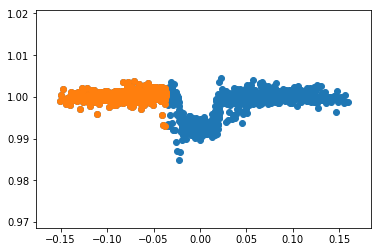

In [30]:
yerr = np.std(flux[:400])
plt.scatter(times, flux)
plt.scatter(times[:400], flux[:400])

<ErrorbarContainer object of 3 artists>

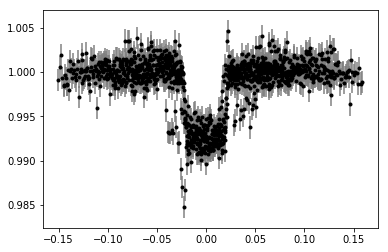

In [31]:
plt.errorbar(times, flux, yerr, color='k', fmt='.', ecolor='gray')

In [32]:
from astropy.constants import R_sun, M_sun, G

rho_sun = M_sun / (4/3 * np.pi * R_sun**3)

rho_star = 47.00335066 * rho_sun
rho_star_upper = (rho_star + 4.2*rho_sun)

In [33]:
import astropy.units as u

ars = float((rho_star * G * (params.per * u.day)**2 / 3 / np.pi)**(1/3))
ars_upper = float((rho_star_upper * G * (params.per * u.day)**2 / 3 / np.pi)**(1/3))
ars_err = ars_upper - ars
ars, ars_err

(81.16401948403904, 2.34884898531557)

In [34]:
def quadratic_to_kipping(u):
    q1 = (u[0] + u[1])**2
    q2 = 0.5 * u[0] / (u[0] + u[1])
    return np.array([q1, q2])

In [35]:
from copy import deepcopy
import robin

def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

def aRs_i(p0, T14, b, transit_params):
    """
    Convert from duration and impact param to a/Rs and inclination

    Parameters
    ----------
    transit_params : `batman.TransitParams`
        Transit parameters
    Returns
    -------
    aRs : float
        Semi-major axis in units of stellar radii
    i : float
        Orbital inclination in degrees
    """
    eccentricity = transit_params.ecc
    omega = transit_params.w
    P = transit_params.per

    # Eccentricity term for b -> a/rs conversion
    beta = (1 - eccentricity**2)/(1 + eccentricity*np.sin(np.radians(omega)))

    # Eccentricity term for duration equation:
    c = (np.sqrt(1 - eccentricity**2) /
         (1 + eccentricity*np.sin(np.radians(omega))))

    i = np.arctan(beta * np.sqrt((1 + p0)**2 - b**2) /
                  (b * np.sin(T14*np.pi / (P*c))))
    aRs = b/(np.cos(i) * beta)
    return aRs, np.degrees(i)

def transit_model(theta, x):
    r0, r1, q1, q2, a, inc, f0, t0 = theta
    trial_params = deepcopy(params)
    trial_params.p0 = r0
    trial_params.p1 = r1
    trial_params.t0 = t0
    trial_params.u = kipping_to_quadratic([q1, q1])

#     a, inc = aRs_i(r0, t14, b, trial_params)
    trial_params.a = a
    trial_params.inc = inc
    
    m = robin.TransitModel(trial_params, x, exp_time=1.92/60/24, supersample_factor=3)
    fluxes = f0 * m.light_curve(trial_params)
    
    return fluxes
    
def lnlike(theta, x, y, yerr):
    r0, r1, q1, q2, a, inc, f0, t0 = theta

    model = transit_model(theta, x) 
    return -0.5*(np.sum((model - y)**2 / yerr**2))


def lnprior(theta):
    r0, r1, q1, q2, a, inc, f0, t0 = theta

    if (0.0 < r0 < 0.2 and 0.0 < r1 < 0.2 and 0 < f0 < 1.5 and 
        1 < a < 100 and 80 < inc < 90 and 0 < q1 < 1 and 0 < q2 < 1 and -0.02 < t0 < 0.02):
        return -0.5 * ((a - ars)/ars_err)**2
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


ndim, nwalkers = 8, 20
#pos = [[params.rp, params.rp, 0] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
pos = []

# q1 = (params.u[0] + params.u[1])**2
# q2 = 0.5 * params.u[0] / (params.u[0] + params.u[1])
# q1 = 0.5

q1 = 0
q2 = 0

while len(pos) < nwalkers: 
    trial_pos = [params.rp, params.rp, q1, q2, params.a, params.inc, 1, 0] + 1e-2*np.random.randn(ndim)
    if np.isfinite(lnprior(trial_pos)):
        pos.append(trial_pos)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, flux, yerr),
                                threads=8)

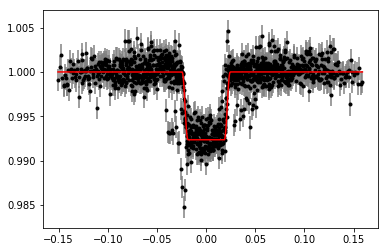

In [36]:
init_f = transit_model([params.rp, params.rp, q1, q2, params.a, params.inc, 1, 0], times)

plt.errorbar(times, flux, yerr, fmt='.', color='k', ecolor='gray')
plt.plot(times, init_f, 'r', zorder=10)

In [37]:
sampler.run_mcmc(pos, 10000); 

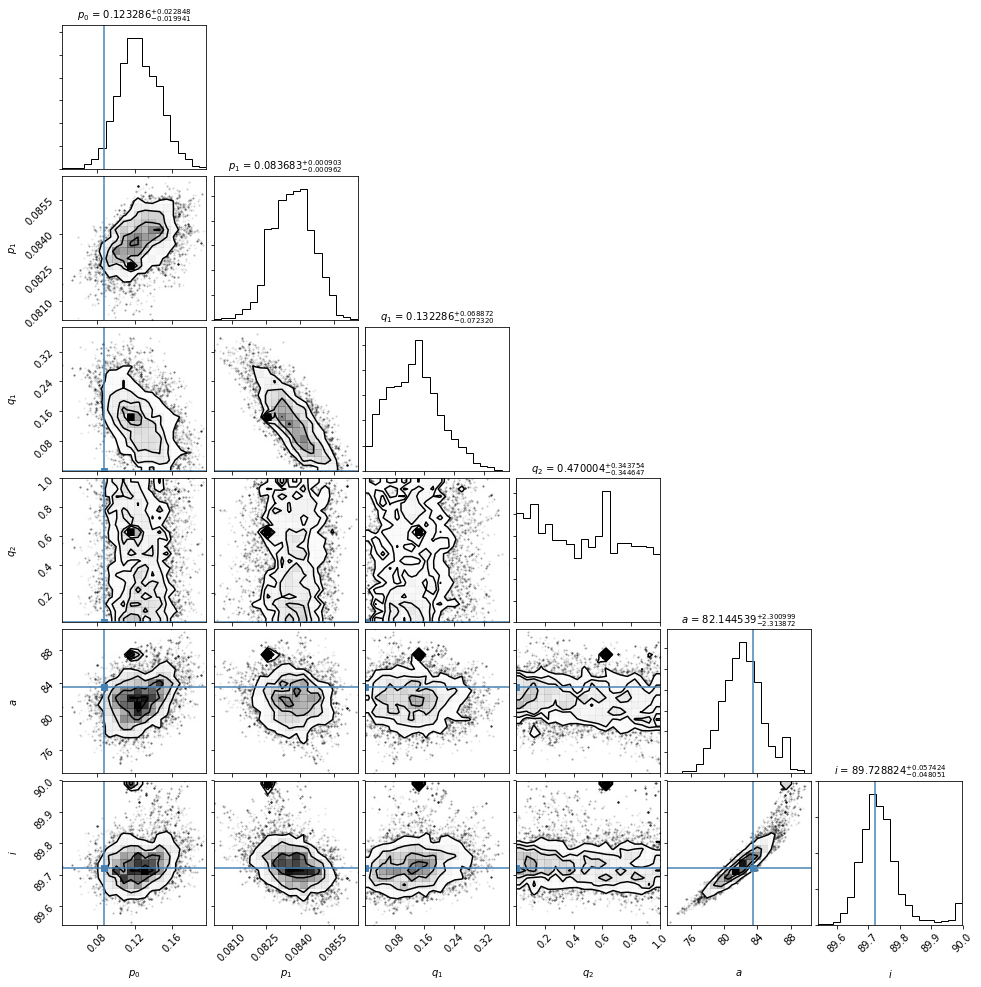

In [38]:
from corner import corner

corner(sampler.chain[:, 9000:, :-2].reshape((-1, ndim-2)), truths=[params.rp, params.rp, q1, q2, params.a, params.inc], 
       labels=['$p_0$', '$p_1$', '$q_1$', '$q_2$', '$a$', '$i$'], show_titles=True, #fig=fig, 
       title_fmt='.6f', title_kwargs=dict(fontsize=10));
plt.savefig('corner_full_trappist1g.pdf', bbox_inches='tight')

In [39]:
np.savetxt('trappist1g_samples.txt', sampler.flatchain)

# class S(object):
#     def __init__(self):
#         self.flatchain = None
    
#     @property
#     def chain(self, ndim=ndim, nwalkers=nwalkers):
#         return self.flatchain.reshape((nwalkers, 10000, ndim))
    
# sampler = S()

# sampler.flatchain = np.loadtxt('trappist1b_samples.txt')

In [40]:
mid_transit_time = np.median(sampler.flatchain[:, -1])

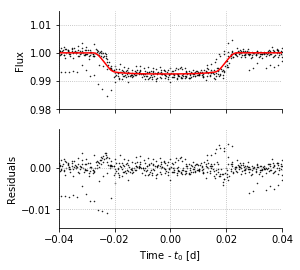

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
ax[0].scatter(times, flux, marker='.', s=1, 
              color='k', rasterized=True)

i = np.argmax(sampler.flatlnprobability, axis=0)
ax[0].plot(times , transit_model(sampler.flatchain[i, :], times), color='r')

ax[1].scatter(times , flux - transit_model(sampler.flatchain[i, :], times), 
              marker='.', s=1, 
              color='k', rasterized=True)

ax[0].set_ylim([0.98, 1.015])
#ax[1].set_ylim([-1000, 1000])

ax[0].set_ylabel('Flux')
ax[1].set(xlabel='Time - $t_0$ [d]', ylabel='Residuals')

for axis in ax:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.grid(ls=':')

ax[0].set_xlim([-0.04, 0.04])
    
fig.savefig('trappist1g_residuals.pdf', bbox_inches='tight', dpi=250)

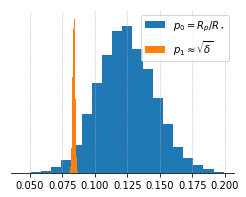

In [42]:
plt.figure(figsize=(4, 3))

fmax = 0
for p, label in zip(sampler.chain[:, 5000:, :2].reshape((-1, ndim-4)).T, 
                    ['$p_0 = R_p/R_\star$', r'$p_1 \approx \sqrt{\delta}$']):
    n, _, _ = plt.hist(p, bins=20, histtype='stepfilled', label=label)
#     if label.startswith('$p_1'):
#         n, _, _ = plt.hist(p[(0.084 < p) & (p < 0.089)], bins=20, histtype='stepfilled', label=label)
#     else:
#         n, _, _ = plt.hist(p, bins=20, histtype='stepfilled', label=label)
    fmax = max([n.max(), fmax])
ax = plt.gca()
ax.grid(ls=':')
ax.legend()
ax.set(yticks=[])


for s in ['right', 'top', 'left']:
    ax.spines[s].set_visible(False)
plt.savefig('trappist1g_agreement.pdf', bbox_inches='tight')